# Maze Solver: Understanding Search Problems

## Author
**Andreas Hummelmose**  
*Computer Science Student, 5th Semester, Aalborg University*  
*LinkedIn: Andreas Hummelmose*

---

## Introduction
This notebook is designed to guide you through the process of building a maze solver using various search algorithms. We will cover both uninformed (blind) and informed (heuristic) search strategies, explaining the underlying concepts of states, actions, state space, and cost functions. Each section provides clear examples and detailed explanations to help you understand how these algorithms work.

## Problem Overview
In search problems, the goal is to find a path from an initial state to a goal state within a defined state space. In our example, we will use a maze to demonstrate this problem, where the objective is to find the shortest path from a start point (S) to an end point (E).

### Formal Definition of a Search Problem
A search problem can be formally defined as a 6-tuple $(S, A, \delta, s_0, G, c)$, where:

- $S$: Set of all possible states.
- $A$: Set of all possible actions.
- $\delta: S \times A \rightarrow S$: Transition function that describes the result of applying an action to a state.
- $s_0 \in S$: The initial state from which the search begins.
- $G \subseteq S$: The set of goal states that satisfy the goal test.
- $c: S \times A \times S \rightarrow \mathbb{R}$: Cost function, defining the cost of transitioning from one state to another via an actionss

### Objective
The objective of a search problem is to find a solution—a sequence of actions $({a_1, a_2, \dots, a_n})$—that transforms the initial state $s_0$ into a goal state $s_g \in G$, such that the path cost $g(s_g)$ is minimized.

## Key Concepts

### State
A state represents a specific configuration of the agent and its environment. In our maze example, a state corresponds to the agent's position within the maze grid.

### Action
An action is a choice that the agent can take in a given state, leading to a transition from the current state to a new state.

### Transition Model
The transition model (or function) describes what state results from performing a given action in a particular state. Formally, it can be expressed as:
$$
\delta: S \times A \rightarrow S
$$

### Goal Test
The goal test is a function that checks whether a given state is the goal state. Formally:
$$
\text{GoalTest}(s): S \rightarrow \{\text{True}, \text{False}\}
$$

### Path Cost
The path cost is the total cost associated with a sequence of actions leading to a particular state from the initial state. It is often denoted as $g(s)$, where $s$ is the current state.

### Frontier
The frontier is a data structure used to keep track of the nodes that have been generated but not yet explored. The frontier can be implemented as a queue, stack, or priority queue, depending on the search strategy.

## Step 1: Creating the Maze
We begin by generating a maze, represented as a 2D grid where cells can either be walls or paths. We use Depth-First Search (DFS) to generate this maze.

### DFS Maze Generation Algorithm
The algorithm initializes a maze filled with walls and then uses DFS to carve out a path. Here’s how it works:

1. **Initialization**:
   - The maze is represented as a 2D grid where `#` represents walls.
   - The start point (S) and end point (E) are placed in the grid.

2. **DFS for Maze Carving**:
   - Starting from the start point, DFS explores neighboring cells.
   - For each cell, DFS randomly selects a neighbor that has not been visited and removes the wall between the current cell and the chosen neighbor.
   - This process continues until all cells have been visited.

In [1]:
import random

def create_maze(width, height):
    # Initialize maze with walls
    maze = [["#" for _ in range(width)] for _ in range(height)]

    # Define start and end points
    end_x, end_y = 1, 1
    start_x, start_y = width - 2, height - 2

    # Set start and end in the maze
    maze[end_y][end_x] = "E"
    maze[start_y][start_x] = "S"

    # Making sure that the start and end points are reachable
    maze[end_y + 1][end_x] = " "
    maze[end_y][end_x + 1] = " "

    maze[start_y - 1][start_x] = " "
    maze[start_y][start_x - 1] = " "


    # Stack for the DFS
    stack = [(start_x, start_y)]

    # Directions for movement (right, down, left, up)
    directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]

    while stack:
        x, y = stack[-1]

        # Find available neighbors
        neighbors = []
        for dx, dy in directions:
            nx, ny = x + dx * 2, y + dy * 2
            if 0 <= nx < width and 0 <= ny < height and maze[ny][nx] == "#":
                neighbors.append((nx, ny, dx, dy))

        if neighbors:
            # Choose a random neighbor
            nx, ny, dx, dy = random.choice(neighbors)
            # Carve the path
            maze[y + dy][x + dx] = " "
            maze[ny][nx] = " "
            stack.append((nx, ny))
        else:
            # No neighbors available, backtrack
            stack.pop()
    return maze

### Example Usage:

Let's generate a maze of size 15x15.
[link text](https://)

In [2]:
maze = create_maze(15, 15)

# Print the maze to visually inspect it
for row in maze:
    print("".join(row))

###############
#E          # #
# # ### ### # #
# # # #   # # #
# # # ### # # #
#   #   # #   #
# ##### # ### #
#       #   # #
####### ### # #
#     # # # # #
# # ### # # ###
# #     # #   #
# ####### ### #
#            S#
###############


## Step 2: Defining the Node Class

To solve the maze, we need a way to represent each state, action, and cost. This is done using a `Node` class, which encapsulates these components.

**Node Class Explanation**:
- **State**: The position of the agent in the maze.
- **Parent**: The node from which the current node was generated.
- **Action**: The action taken to reach this node from the parent.
- **Path Cost**: The cumulative cost to reach this node from the start.


In [3]:
class Node:
    def __init__(self, state, parent, action, cost=1, compare_by="cost") -> None:
        self.state = state
        self.parent = parent
        self.action = action
        self.cost = cost
        self.compare_by = compare_by
        self.pathsum = cost + (self.parent.pathsum if self.parent else 0)

    def get_path(self, give="cost"):
        path = []
        current_node = self
        while current_node is not None:
            path.append((current_node.action, current_node.state, current_node.cost if give == "cost" else current_node.pathsum))
            current_node = current_node.parent
        path.reverse()
        return path

    def __lt__(self, other):
        return self.cost < other.cost if self.compare_by == "cost" else self.pathsum < other.pathsum

## Step 3: Implementing Search Algorithms
We now explore different search algorithms to solve the maze.

###**Uninformed Search Algorithms**
These algorithms do not use any domain-specific knowledge.

#### **Depth-First Search (DFS)**
DFS explores as far as possible along a branch before backtracking. It is implemented using a stack.


In [4]:
class Stack_Frontier:
    """Represents a frontier that uses a stack data structure (LIFO) with no cost"""

    def __init__(self) -> None:
        """The frontier will represent the current nodes to be explored"""
        self.frontier = []

    def add(self, state, parent, action) -> None:
        self.frontier.append(Node(state, parent, action))

    def empty(self) -> bool:
        return len(self.frontier) == 0

    def length(self) -> int:
        return len(self.frontier)

    def contains_state(self, state) -> bool:
        return any(node.state == state for node in self.frontier)

    def remove(self) -> Node:
        if self.length() == 0:
            raise Exception("Empty frontier")
        else:
            node_to_remove = self.frontier[-1]
            self.frontier = self.frontier[:-1]
            return node_to_remove

#### Breadth-First Search (BFS)

BFS explores all nodes at the present depth level before moving on to the nodes at the next depth level. It uses a queue.


In [5]:
class Queue_Frontier:
    """Represents a frontier that uses a queue data structure (FIFO) with no cost"""

    def __init__(self) -> None:
        """The frontier will represent the current nodes to be explored"""
        self.frontier = []

    def add(self, state, parent, action) -> None:
        self.frontier.append(Node(state, parent, action))

    def empty(self) -> bool:
        return len(self.frontier) == 0

    def length(self) -> int:
        return len(self.frontier)

    def contains_state(self, state) -> bool:
        return any(node.state == state for node in self.frontier)

    def remove(self) -> Node:
        if self.length() == 0:
            raise Exception("The frontier is empty")
        else:
            node_to_remove = self.frontier[0]
            self.frontier = self.frontier[1:]
            return node_to_remove

## Informed Search Algorithms
These algorithms use heuristics to guide the search process more efficiently

### **Greedy Best-First Search (GBFS)**

GBFS selects the node that appears to be closest to the goal, using a heuristic function.


In [6]:
import heapq

class GreedyFrontier:
    def __init__(self, end_point, heuristic) -> None:
        """The frontier will represent the current nodes to be explored"""
        self.frontier = []
        self.end_point = end_point
        self.heuristic = heuristic
        self.step = 0

    def add(self, state, parent, action) -> None:
        priority = self.heuristic(state, self.end_point)
        heapq.heappush(self.frontier, Node(state, parent, action, priority, "cost"))
        self.step += 1

    def empty(self) -> bool:
        return len(self.frontier) == 0

    def length(self) -> int:
        return len(self.frontier)

    def contains_state(self, state) -> bool:
        return any(node.state == state for node in self.frontier)

    def remove(self) -> Node:
        if self.empty():
            raise Exception("Empty frontier")
        else:
            node = heapq.heappop(self.frontier)
            return node

### **A* Search**

A* combines the actual cost to reach the current node (g) and the heuristic estimate to the goal (h), expanding the node with the lowest total estimated cost

$$f(n)=g(n)+h(n)$$

In [7]:
class AStarFrontier:
    def __init__(self, end_point, heuristic) -> None:
        """The frontier will represent the current nodes to be explored"""
        self.frontier = []
        self.end_point = end_point
        self.heuristic = heuristic
        self.step = 0

    def add(self, state, parent, action) -> None:
        g = self.step
        h = self.heuristic(state, self.end_point)
        f = g + h
        heapq.heappush(self.frontier, Node(state, parent, action, f, "cost"))
        self.step += 1

    def empty(self) -> bool:
        return len(self.frontier) == 0

    def length(self) -> int:
        return len(self.frontier)

    def contains_state(self, state) -> bool:
        return any(node.state == state for node in self.frontier)

    def remove(self) -> Node:
        if self.empty():
            raise Exception("Empty frontier")
        else:
            node = heapq.heappop(self.frontier)
            return node

### **Heuristic Functions**
The effectiveness of informed search algorithms heavily relies on the quality of the heuristic function.

#### **Euclidean Distance Heuristic**
This heuristic calculates the straight-line distance between two points in a plane. It’s often used in problems where the movement is not restricted to grid lines. The Euclidean distance between two points $(x_1, y_1)$ and $(x_2, y_2)$ has the fomula:
  $$h(n) = \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}$$

#### **Manhattan Distance Heuristic**
This heuristic calculates the distance between two points measured along axes at right angles. It’s used in grid-based problems where movement is restricted to horizontal and vertical directions. The Manhattan distance between two points $(x_1, y_1)$ and $(x_2, y_2)$ has the fomula:
  $$h(n) = |x_2 - x_1| + |y_2 - y_1|$$


### Step 4: Maze Utilities for Parsing and Visualizing

#### **MazeUtils Class**

To facilitate maze parsing and solution visualization, we'll use the `MazeUtils` class.


In [8]:
import numpy as np
import matplotlib.pyplot as plt

class MazeUtils:
    def __init__(self) -> None:
        pass

    def maze_parser(self, maze):
        self.height = len(maze)
        self.width = len(maze[0])
        self.walls = [[cell == "#" for cell in row] for row in maze]
        start = end = None

        for y in range(self.height):
            for x in range(self.width):
                if maze[y][x] == "S":
                    start = (x, y)
                elif maze[y][x] == "E":
                    end = (x, y)

        if not start or not end:
            raise ValueError("Maze must have a start (S) and an end (E)")

        self.start_point = start
        self.end_point = end

        return self.height, self.width, self.start_point, self.end_point, self.walls

    def print_solution(
        self, show_visited=False, show_amount=False, highlight_current=None, title=None
    ):
        # Define the grid with walls and empty spaces
        maze = np.zeros((self.height, self.width))

        for y in range(self.height):
            for x in range(self.width):
                if self.walls[y][x]:
                    maze[y][x] = 1  # Walls

        # Mark visited nodes if show_visited is True
        if show_visited:
            for visited_state, cost in self.visited:
                visited_x, visited_y = visited_state
                maze[visited_y][visited_x] = 2  # Visited nodes (not part of the solution)

        # Mark the solution path
        if self.solution is not None:
            for action, (path_x, path_y), amount in self.solution:
                maze[path_y][path_x] = 3  # Solution path

        # Mark the start and end points
        start_x, start_y = self.start_point
        end_x, end_y = self.end_point
        maze[start_y][start_x] = 4  # Start
        maze[end_y][end_x] = 5  # End

        # Highlight current node
        if highlight_current:
            current_x, current_y = highlight_current
            maze[current_y][current_x] = 6  # Current node

        # Define the color map
        cmap = plt.cm.colors.ListedColormap(
            ["white", "black", "yellow", "green", "blue", "red", "purple"]
        )
        bounds = [0, 1, 2, 3, 4, 5, 6, 7]
        norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)

        # Plot the maze
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(maze, cmap=cmap, norm=norm)

        # Add gridlines
        ax.grid(which="major", axis="both", linestyle="-", color="k", linewidth=2)
        ax.set_xticks(np.arange(-0.5, self.width, 1))
        ax.set_yticks(np.arange(-0.5, self.height, 1))

        # Remove tick labels
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        # Show amounts if requested
        if show_amount:
            for visited_state, cost in self.visited:
                visited_x, visited_y = visited_state
                ax.text(
                    visited_x,
                    visited_y,
                    f"{cost:.1f}",
                    ha="center",
                    va="center",
                    color="black",
                    fontweight="bold",
                )

        if title:
            plt.title(title)

        # Show the plot
        plt.show()

### Step 5: Implementing the MazeSolver with MazeUtils

Now, we'll integrate `MazeUtils` with the `MazeSolver` to parse the maze and visualize the results.

In [9]:
class MazeSolver(MazeUtils):
    def __init__(self, maze):
        super().__init__()
        self.maze = maze
        self.height, self.width, self.start_point, self.end_point, self.walls = self.maze_parser(maze)
        self.solution = None
        self.visited = set()

    def get_valid_actions(self, state):
        actions = []
        x, y = state

        if x + 1 < self.width and not self.walls[y][x + 1]:
            actions.append(("Right", (x + 1, y)))
        if x - 1 >= 0 and not self.walls[y][x - 1]:
            actions.append(("Left", (x - 1, y)))
        if y + 1 < self.height and not self.walls[y + 1][x]:
            actions.append(("Down", (x, y + 1)))
        if y - 1 >= 0 and not self.walls[y - 1][x]:
            actions.append(("Up", (x, y - 1)))
        return actions

    def solve(self, frontier_type, frontier_params=None, grid_text="cost"):
        if frontier_params is None:
            frontier_params = {}
        frontier = frontier_type(**frontier_params)

        frontier.add(self.start_point, None, None)
        self.visited = set()

        while not frontier.empty():
            current_node = frontier.remove()

            if current_node.state == self.end_point:
                self.solution = current_node.get_path(grid_text)
                return

            if current_node.state not in self.visited:
                self.visited.add(
                    (
                        current_node.state,
                        current_node.cost
                        if grid_text == "cost"
                        else current_node.pathsum - current_node.cost,
                    )
                )

                actions = self.get_valid_actions(current_node.state)

                for action, state in actions:
                    if state not in [
                        v[0] for v in self.visited
                    ] and not frontier.contains_state(state):
                        frontier.add(state, current_node, action)

        self.solution = None

    def display_solution(self, show_visited=False, show_amount=False):
        self.print_solution(show_visited=show_visited, show_amount=show_amount)

### Example Usage: Solving the Maze

Let's test each algorithm with our maze.

#### Depth-First Search

DFS Solution:


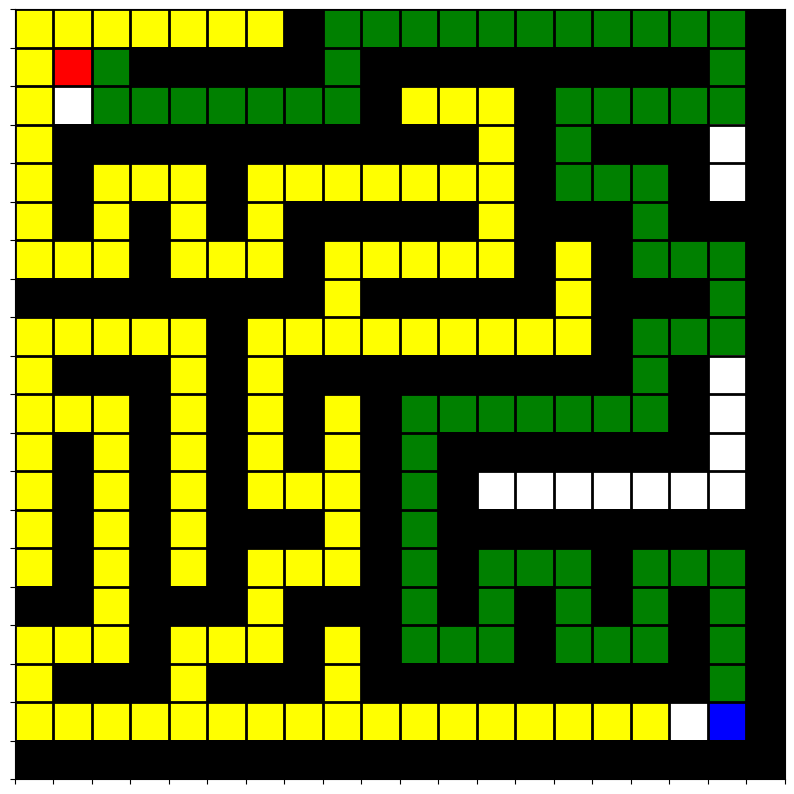

In [10]:
# Create the maze and solver
maze = create_maze(20, 20)
solver = MazeSolver(maze)

# Solve using DFS
solver.solve(Stack_Frontier)
print("DFS Solution:")
solver.display_solution(show_visited=True, show_amount=False)

#### Breadth-First Search


BFS Solution:


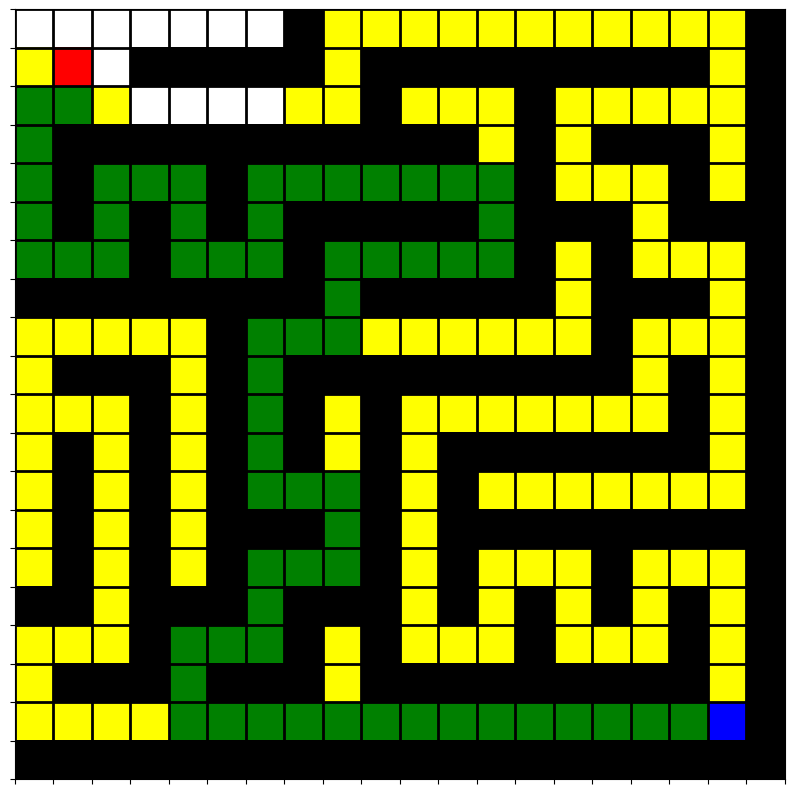

In [11]:
# Solve using BFS
solver.solve(Queue_Frontier)
print("BFS Solution:")
solver.display_solution(show_visited=True, show_amount=False)

#### Greedy Best-First Search


GBFS Solution:


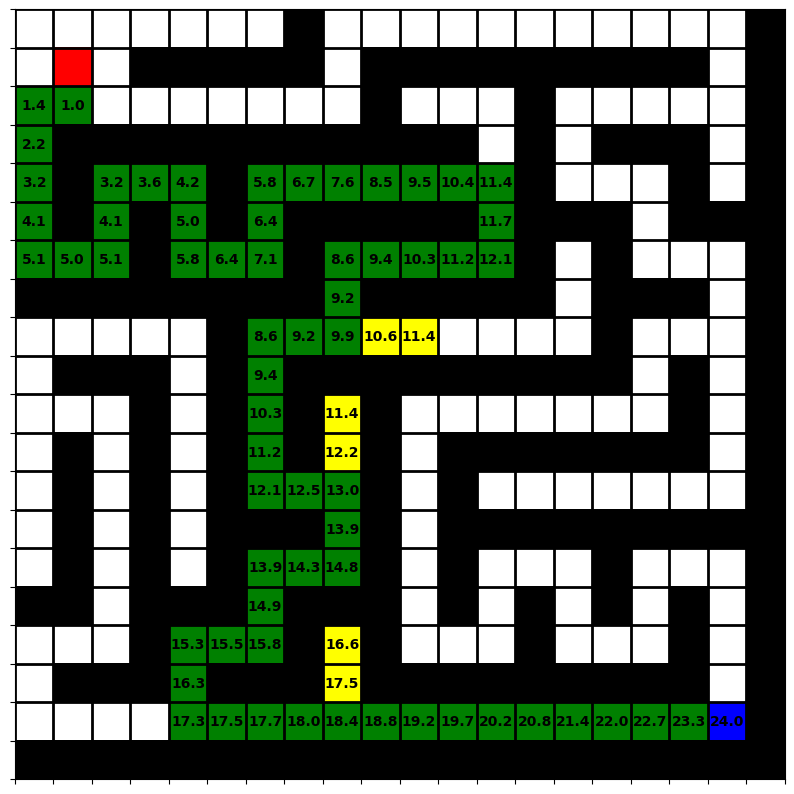

In [12]:
# Define a simple Euclidean heuristic
def euclidean_heuristic(state, goal):
    return ((state[0] - goal[0]) ** 2 + (state[1] - goal[1]) ** 2) ** 0.5

# Solve using GBFS
solver.solve(GreedyFrontier, {"end_point": solver.end_point, "heuristic": euclidean_heuristic})
print("GBFS Solution:")
solver.display_solution(show_visited=True, show_amount=True)

#### A* Search

A* Solution:


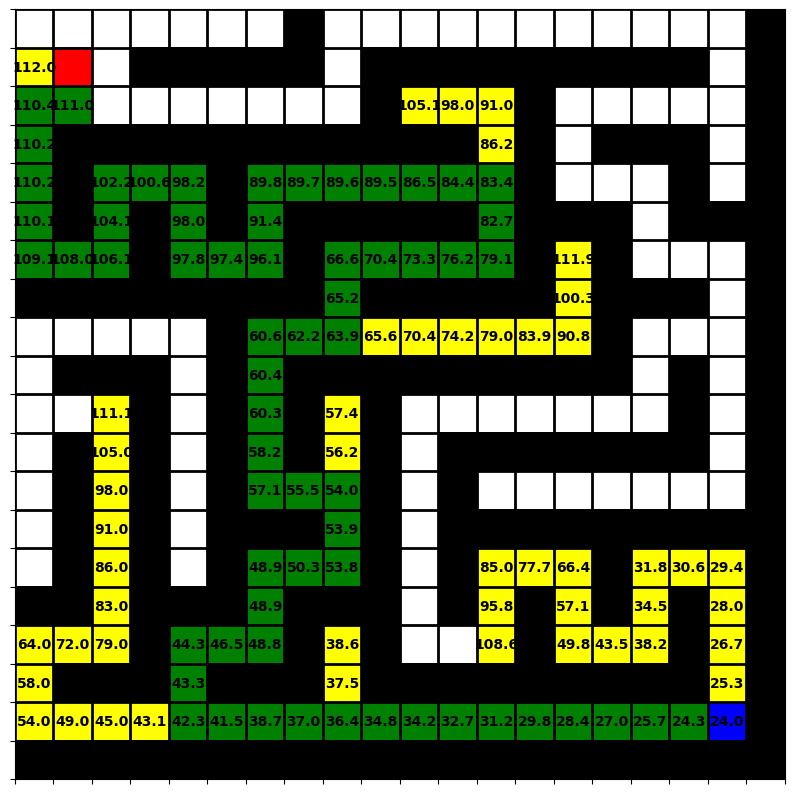

In [13]:
# Solve using A*
solver.solve(AStarFrontier, {"end_point": solver.end_point, "heuristic": euclidean_heuristic})
print("A* Solution:")
solver.display_solution(show_visited=True, show_amount=True)